## Modeling 
In this notebook we start to build machine learning models. We check both mean and median imputation for NaN values. Use pipeline and use GridSearch to identify the best K for our model. Then we will determined best model by assesing their performance. 

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime


## Load Data 

In [2]:
IGDB = pd.read_csv('./data/IGDB_pre_processing.csv')

In [3]:
IGDB.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
IGDB.dtypes

id                       int64
age_ratings             object
category                 int64
collection             float64
cover                  float64
created_at               int64
external_games          object
first_release_date      object
follows                float64
game_modes              object
genres                  object
involved_companies      object
keywords                object
name                    object
platforms               object
player_perspectives     object
release_dates           object
screenshots             object
similar_games           object
slug                    object
summary                 object
tags                    object
themes                  object
updated_at               int64
url                     object
websites                object
checksum                object
total_rating           float64
total_rating_count     float64
rating_count           float64
console                float64
operating_system       float64
year    

In [5]:
IGDB.shape

(4265, 33)

### Train/Test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(IGDB.drop(columns='total_rating'), 
                                                    IGDB.total_rating, test_size=0.3, 
                                                    random_state=47)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2985, 32), (1280, 32), (2985,), (1280,))

In [8]:
#drop non-numeric columns from `X_train` and `X_test`. Use 'inplace=True'
names_list = IGDB.select_dtypes(include=['object'])

In [9]:
names_list_columns = names_list.columns

In [10]:
names_train = X_train[names_list_columns]
names_test = X_test[names_list_columns]
X_train.drop(columns=names_list_columns, inplace=True)
X_test.drop(columns=names_list_columns, inplace=True)
X_train.shape, X_test.shape

((2985, 12), (1280, 12))

In [11]:
X_train.dtypes

id                      int64
category                int64
collection            float64
cover                 float64
created_at              int64
follows               float64
updated_at              int64
total_rating_count    float64
rating_count          float64
console               float64
operating_system      float64
year                    int64
dtype: object

In [12]:
X_test.dtypes

id                      int64
category                int64
collection            float64
cover                 float64
created_at              int64
follows               float64
updated_at              int64
total_rating_count    float64
rating_count          float64
console               float64
operating_system      float64
year                    int64
dtype: object

We only have numeric features in X now. 

### Mean as a predictor

In [13]:
# Fitting dummy regressor on the training data
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[69.06432161]])

Checking performance metrics of using the mean as a predictor for a game's rating 

In [14]:
train_mean = y_train.mean()
train_mean

69.0643216080402

In [15]:
y_tr_pred = train_mean * np.ones(len(y_train))
y_tr_pred[:5]

array([69.06432161, 69.06432161, 69.06432161, 69.06432161, 69.06432161])

In [16]:
y_te_pred = train_mean * np.ones(len(y_test))

In [17]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.00024439880428972494)

In [18]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(10.976166595119652, 10.723575690954773)

With this method we might expect to be off by around 10-11 points in rating if guessing the game rating on an average of known values 

In [19]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(205.6240034342567, 195.37713035971314)

We get a slightly better MSE on the test set thn the train set. 

## Initial Models

### Imputing missing values with the median

In [21]:
# imputing missing values: check median 
X_defaults_median = X_train.median()
X_defaults_median

id                    4.681000e+03
category              0.000000e+00
collection            7.770000e+02
cover                 1.176120e+05
created_at            1.391049e+09
follows               6.000000e+00
updated_at            1.693550e+09
total_rating_count    1.500000e+01
rating_count          1.600000e+01
console               1.000000e+00
operating_system      1.000000e+00
year                  2.006000e+03
dtype: float64

In [22]:
#Applying the imputation to both tran and test splits 
X_tr = X_train.fillna(X_defaults_median)
X_te = X_test.fillna(X_defaults_median)

In [23]:
#Scaling the data to put them all on a consisten scale.
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

#### Training the model on the tran split 

In [24]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

In [25]:
# Making preditions using the model 
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

#### Assesing model performance 

In [26]:
# Assess model performance 
median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
median_r2

(0.15404282386988033, 0.15191237916366784)

In [27]:
median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
median_mae

(10.04083558648435, 9.88464626582542)

Using this model, on average we expect to estimate a game rating within 10 points or so of the true rating. This is just slightly better than from guessing the average. 

In [28]:
median_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
median_mse

(173.94910128981385, 165.65643941688268)

### Imputing missing values with the mean 

In [29]:
# imputing missing values: check mean
X_defaults_mean = X_train.mean()
X_defaults_mean

id                    4.770503e+03
category              4.569514e-01
collection            1.639477e+03
cover                 1.421137e+05
created_at            1.382787e+09
follows               2.812309e+01
updated_at            1.692100e+09
total_rating_count    6.961206e+01
rating_count          7.425878e+01
console               7.942359e-01
operating_system      6.816354e-01
year                  2.002724e+03
dtype: float64

By eye, some replacement values are higher than using the median. 

In [30]:
# Applying imputation to both train and test split
X_tr = X_train.fillna(X_defaults_mean)
X_te = X_test.fillna(X_defaults_mean)

In [31]:
#Scaling the data 
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

In [32]:
# Training the model 
lm = LinearRegression().fit(X_tr_scaled, y_train)

In [33]:
#Making predictions 
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

In [34]:
# Assess model performance 
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.16892109891438334, 0.16525197272986913)

In [35]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(9.90754181976817, 9.781353649946801)

In [36]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(170.88977081096715, 163.050824714871)

These results are slightly better that using the median. 

## Linear Model using pipeline

In [37]:
#Defining pipeline 
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(), 
    LinearRegression()
)

In [38]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [39]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [40]:
# Assess performance
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.15404282386988033, 0.15191237916366784)

In [41]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(10.04083558648435, 9.88464626582542)

In [42]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(173.94910128981385, 165.65643941688268)

Results are the same as above but much quicker with pipeline. 

In [43]:
# pipeline with f_regression 
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [44]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x7f8c31969c10>)),
                ('linearregression', LinearRegression())])

In [45]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [46]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.15313562758505683, 0.15249867862958266)

In [47]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(10.041571518485952, 9.880472326045497)

The difference is almost inperceptable. We will check which K is best 

### Hyperparameter search using GridSearchCV

In [48]:
#Available parameters 
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [49]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [50]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [51]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7f8c31969c10>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12]})

In [52]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [53]:
lr_grid_cv.best_params_

{'selectkbest__k': 10}

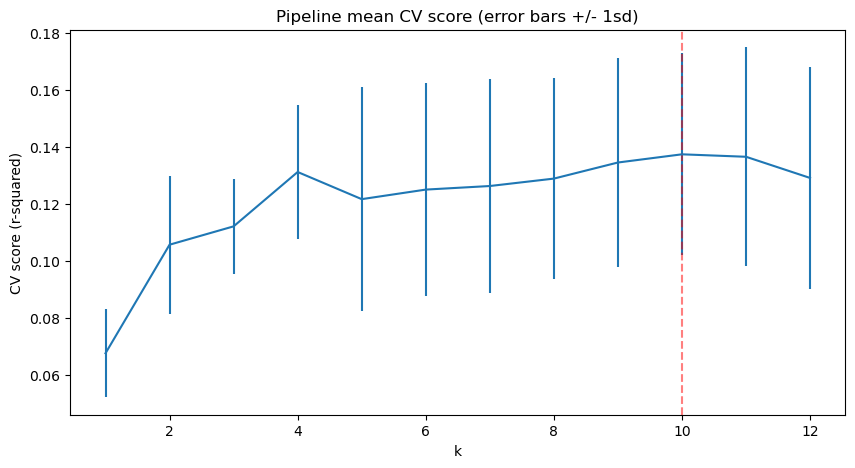

In [54]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

The above suggests a good value for K is 10. There was an initial rapid increase with k followed by a slight decline. Visually, the variance of the results does not seem to significantly increase as K increases. 

In [55]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [56]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

total_rating_count    84.173306
id                     2.028333
category               1.160894
console                0.647866
updated_at             0.548299
operating_system       0.484928
collection            -0.697265
follows               -2.620646
created_at            -4.027832
rating_count         -78.771101
dtype: float64

This suggests that total rating count is our biggest positive feature. This makes intuitive sense as people tend to take more time to rate games they find great or terrible. It is also consistent with what was seen during EDA work. The other positive features are id and category followed by console, updated at and operating system. 

## Random Forest 

In [57]:
#Random Foresst Regressor
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [58]:
#Fit and assess performance
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [59]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.33072745, 0.29132572, 0.27254468, 0.27488803, 0.31771359])

In [60]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.2974398946266181, 0.02317250919358801)

### Hyperparameter search using GridSearchCV

In [61]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

In [62]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [63]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'simpleimputer__strategy': [

In [64]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 297,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

Looks like imputing with the mean helps as well as scaling the features.

In [65]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.35198426, 0.33305695, 0.30632227, 0.30010656, 0.33452252])

In [66]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.32519851139698897, 0.019246230323216894)

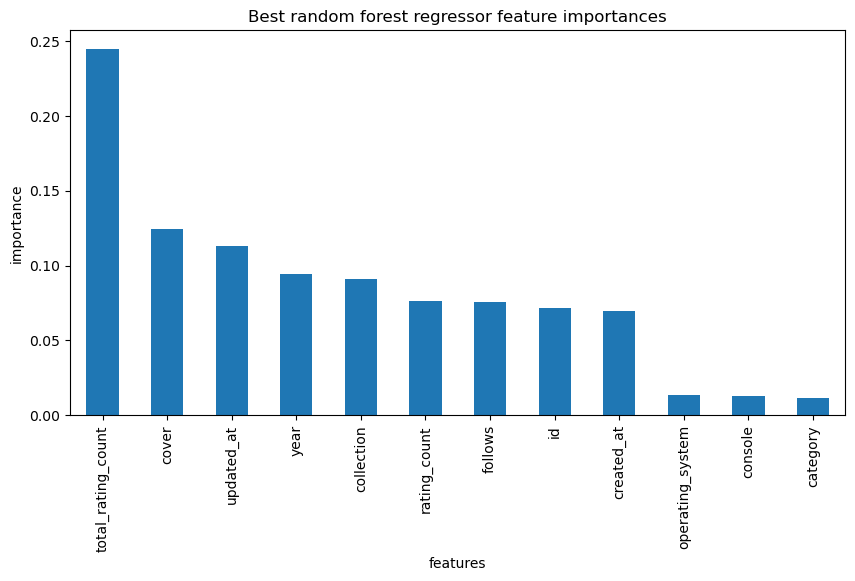

In [67]:
#Feature importance in descending order
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

The top feature is in common with our linear model: total_rating_count. Cover follows second in this RF mdoel while it was negative for linear model. updated_at and id are the other top features in RF model that are found as positive in LM.

## Final Model Selection 

#### Linear Regression model performance

In [68]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [69]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(10.093403262811606, 0.285383584453643)

In [70]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

9.880472326045497

#### Random forest regression performance 

In [71]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [72]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(8.71055501976775, 0.21140915235790106)

In [73]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

8.58476694023569

### Conclusion 
The random forest model has a lower cross-validation mean absolute error by over 1 point. It also exhibits less variability. Verifying performance on the test set produces performance consistent with the cross-validation results.

## Data quantity assesment

In [74]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

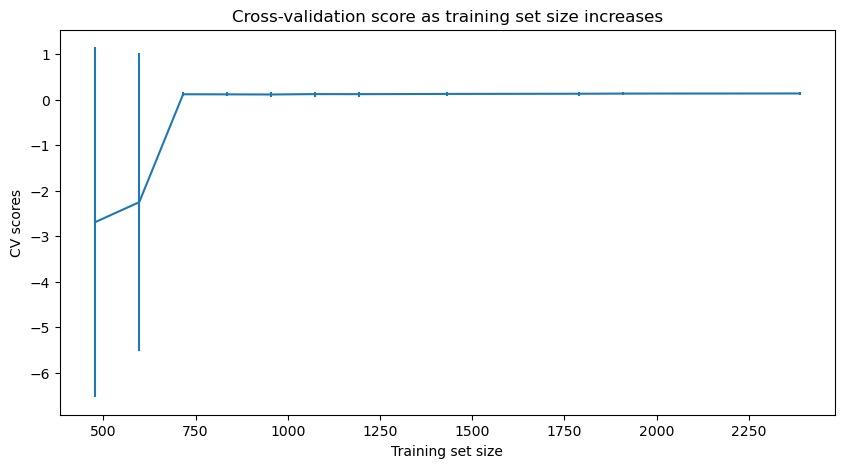

In [75]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

This shoes that we seem to have plenty of data. There is an initial rapid improvement in model scores but it levels off by sample size 750.

## Summary 

We started by looking at the mean value as a predictor or a baseline for our pricing model. We stablished a 70/30 train/test split. We then used sklearn’s DummyRegressor. 
Moving onto metrics to assess how good a set of values agree with another. First, we looked at R^2 which provides the proportion of variance in the dependent variable (total rating) that is predicted by our model. R^2 was zero for our training set given that the first time around we used the average as a predictor. We also looked at mean absolute error which provides the average of the absolute errors. While using the average as a predictor we might expect to be off by 10-11 points in rating when guessing the total rating based on an average of known values.

Using a simple linear regression model by imputing the median for missing values on both train and test split provided us slightly better metrics compared to simply using only the average price. Based on the mean absolute error with this model we would expect to estimate total rating of a game within 9-10 points or so of the real rating. We also tried imputing the mean for missing values, performance metrics did not seem significantly different from when the median was used for imputing missing values. 

We also checked what the different number of features (k) considered would do to the model. In order to prevent overfitting and assess performance, we used cross-validation on our training model. Using best_params_ attribute and selectkbest__k the model provided us with a good value of K being 10. 
Total_rating_count, id, category, console, updated_at, and operating_system were the positive features using LM. 

To verify other options, we also used a random forest model on our data, for this case, imputing with the mean helped to train the model as well as scaling the features. When checking on regressor feature importance for this model, we found that the top 4 features include: total_rating_count, cover, updated_at, year, and collection. All but 2 that differ from the positive features provided usind the linear model. 

In conclusion, the random forest model has a lower cross-validation mean absolute error by over 1 point. It also exhibits less variability. We also verified if the available data is sufficient for the model. We ran the learning_curve function to test whether we need the full training size or just a partial size and we found that the training size was maxed out at about 750. This indicates we have plenty of data.